# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [n_estimators](#n_estimators)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create a prototype classifier using a bagged GaussianNB. In this notebook, we perform grid searches over var_smoothing using out-of-bag accuracy instead of cross validation.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# typing
from typing import Sequence

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.23 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 101 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather(
        f"{FEATURES_FOLDER}/scaled_features_ready_for_selection.feather"
    ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
gnb_features = ["spherical-LDA1", "spherical-LDA2"]
_ = gc_collect()

time: 228 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 51 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           85740 non-null  float64
 1   LDA2                                                                           85740 non-null  float64
 2   ocLDA_neg                                                                      85740 non-null  float64
 3   ocLDA_neu                                                                      85740 non-null  float64
 4   ocLDA_pos                                                                      85740 non-null  float64
 5   ocSVM_sgdlinear_LDA1                                                           85740 non-null  float64
 6   ocSVM_sgdlinear_LDA2 

In [7]:
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
_ = gc_collect()

time: 104 ms


# var_smoothing

In [8]:
def tune_var_smoothing(search_space: Sequence, outfile: str) -> None:
    """Run tuning procedure"""
    df = data.loc[:, gnb_features]
    make_gnb = lambda var_smoothing: BaggingClassifier(
        base_estimator=GaussianNB(var_smoothing=var_smoothing),
        n_estimators=50,
        oob_score=True,
        n_jobs=-1,
        random_state=SEED,
        # verbose=1,
    ).fit(df, y_true)
    for hp in tqdm(search_space):
        gnb = make_gnb(hp)
        results["var_smoothing"].append(hp)
        results["oob_score"].append(gnb.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

    df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
    print(df.sort_values(by="oob_score", ascending=False).head(10))
    print(df.sort_values(by="log_loss", ascending=True).head(10))
    print(df.sort_values(by="auroc", ascending=False).head(10))
    df.plot(x="var_smoothing")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

    df.columns = df.columns.astype(str)
    df.reset_index(drop=True).to_feather(f"{DATA_OUT_FOLDER}/{outfile}.feather")


_ = gc_collect()

time: 107 ms


  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
44       0.147077   0.677094  0.755066  0.822238
1        0.149717   0.677094  0.754863  0.822268
15       0.148451   0.677082  0.754959  0.822253
5        0.146096   0.677000  0.755143  0.822227
29       0.142554   0.676895  0.755433  0.822185
25       0.157121   0.676837  0.754340  0.822351
47       0.171630   0.676639  0.753496  0.822509
30       0.169402   0.676592  0.753611  0.822485
34       0.238281   0.676499  0.752109  0.823163
20       0.223262   0.676487  0.752117  0.823025
    var_smoothing  oob_score  log_loss     auroc
23       0.225742   0.676452  0.752105  0.823048
34       0.238281   0.676499  0.752109  0.823163
36       0.224389   0.676382  0.752111  0.823036
20       0.223262   0.676487  0.752117  0.823025
9        0.216340   0.676359  0.752174  0.822961
11       0.248270   0.676347  0.752186  0.823251
10       0.249406   0.676394  0.752199  0.823261
12       0.250074   0.676300  0.752207  0.823266
4        0.205622   

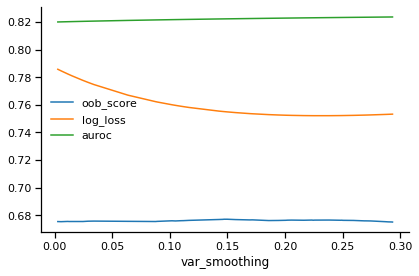

time: 1min 18s


In [9]:
tune_var_smoothing(
    search_space=np.random.uniform(0.0, 0.3, size=50), outfile="var_smoothing1"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
1        0.149717   0.677094  0.754863  0.822268
44       0.147077   0.677094  0.755066  0.822238
15       0.148451   0.677082  0.754959  0.822253
5        0.146096   0.677000  0.755143  0.822227
29       0.142554   0.676895  0.755433  0.822185
25       0.157121   0.676837  0.754340  0.822351
47       0.171630   0.676639  0.753496  0.822509
78       0.175109   0.676604  0.753326  0.822546
30       0.169402   0.676592  0.753611  0.822485
34       0.238281   0.676499  0.752109  0.823163
    var_smoothing  oob_score  log_loss     auroc
23       0.225742   0.676452  0.752105  0.823048
34       0.238281   0.676499  0.752109  0.823163
36       0.224389   0.676382  0.752111  0.823036
20       0.223262   0.676487  0.752117  0.823025
9        0.216340   0.676359  0.752174  0.822961
11       0.248270   0.676347  0.752186  0.823251
10       0.249406   0.676394  0.752199  0.823261
12       0.250074   0.676300  0.752207  0.823266
4        0.205622   

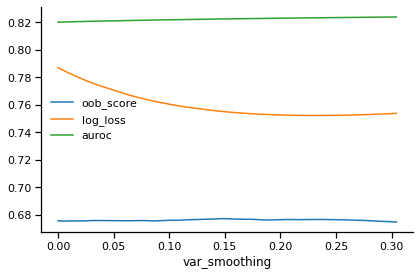

time: 1min 15s


In [10]:
tune_var_smoothing(
    search_space=loguniform.rvs(1e-11, 0.4, size=50), outfile="var_smoothing2"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
103       0.148414   0.677105  0.754962  0.822253
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
1         0.149717   0.677094  0.754863  0.822268
15        0.148451   0.677082  0.754959  0.822253
136       0.152474   0.677035  0.754661  0.822299
121       0.144589   0.677012  0.755264  0.822209
5         0.146096   0.677000  0.755143  0.822227
29        0.142554   0.676895  0.755433  0.822185
142       0.142194   0.676860  0.755463  0.822181
     var_smoothing  oob_score  log_loss     auroc
132       0.229770   0.676674  0.752095  0.823086
23        0.225742   0.676452  0.752105  0.823048
34        0.238281   0.676499  0.752109  0.823163
36        0.224389   0.676382  0.752111  0.823036
20        0.223262   0.676487  0.752117  0.823025
108       0.241712   0.676277  0.752129  0.823193
106       0.243845   0.676289  0.752144  0.823212
123       0.217291   0.676359  0.752164  0.822970


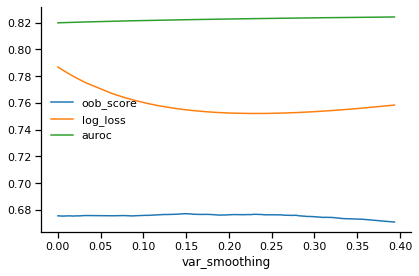

time: 1min 17s


In [11]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.1, 0.4, size=50), outfile="var_smoothing3"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
103       0.148414   0.677105  0.754962  0.822253
113       0.147066   0.677094  0.755067  0.822238
1         0.149717   0.677094  0.754863  0.822268
44        0.147077   0.677094  0.755066  0.822238
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
136       0.152474   0.677035  0.754661  0.822299
121       0.144589   0.677012  0.755264  0.822209
5         0.146096   0.677000  0.755143  0.822227
195       0.153412   0.676942  0.754594  0.822309
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


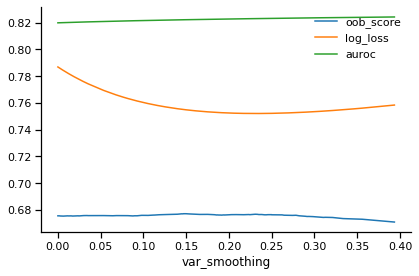

time: 1min 12s


In [12]:
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 0.25, size=50), outfile="var_smoothing4"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
103       0.148414   0.677105  0.754962  0.822253
220       0.148896   0.677105  0.754925  0.822259
211       0.149748   0.677094  0.754861  0.822268
44        0.147077   0.677094  0.755066  0.822238
226       0.146812   0.677094  0.755086  0.822235
113       0.147066   0.677094  0.755067  0.822238
1         0.149717   0.677094  0.754863  0.822268
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
207       0.149977   0.677059  0.754844  0.822271
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


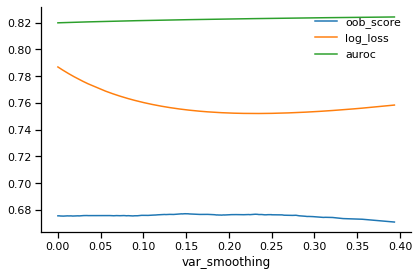

time: 1min 17s


In [13]:
tune_var_smoothing(
    search_space=np.random.uniform(0.05, 0.15, size=50), outfile="var_smoothing5"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
103       0.148414   0.677105  0.754962  0.822253
220       0.148896   0.677105  0.754925  0.822259
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
1         0.149717   0.677094  0.754863  0.822268
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
207       0.149977   0.677059  0.754844  0.822271
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


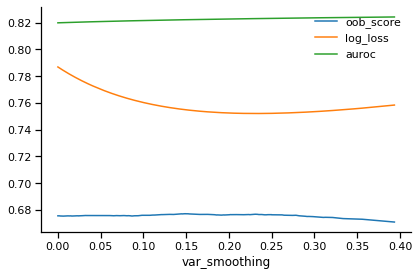

time: 1min 17s


In [14]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 0.25, size=50), outfile="var_smoothing6"
)

  0%|          | 0/15 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
1         0.149717   0.677094  0.754863  0.822268
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
207       0.149977   0.677059  0.754844  0.822271
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


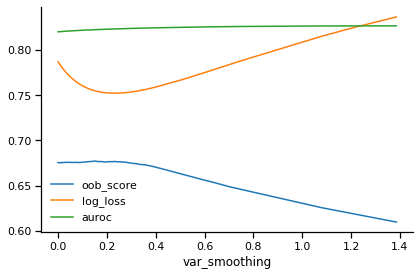

  0%|          | 0/15 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
1         0.149717   0.677094  0.754863  0.822268
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
207       0.149977   0.677059  0.754844  0.822271
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


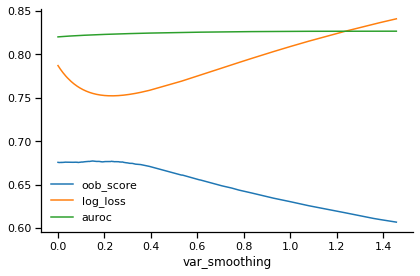

time: 47.9 s


In [15]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 1.5, size=15), outfile="var_smoothing7"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 1.5, size=15), outfile="var_smoothing8"
)

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
211       0.149748   0.677094  0.754861  0.822268
44        0.147077   0.677094  0.755066  0.822238
1         0.149717   0.677094  0.754863  0.822268
226       0.146812   0.677094  0.755086  0.822235
113       0.147066   0.677094  0.755067  0.822238
15        0.148451   0.677082  0.754959  0.822253
164       0.149037   0.677070  0.754915  0.822260
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


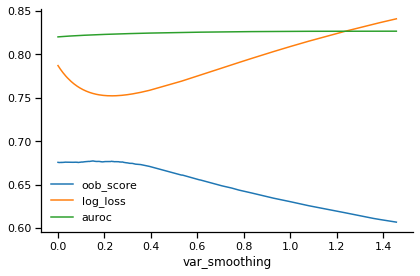

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
103       0.148414   0.677105  0.754962  0.822253
220       0.148896   0.677105  0.754925  0.822259
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
348       0.147016   0.677094  0.755070  0.822237
1         0.149717   0.677094  0.754863  0.822268
15        0.148451   0.677082  0.754959  0.822253
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


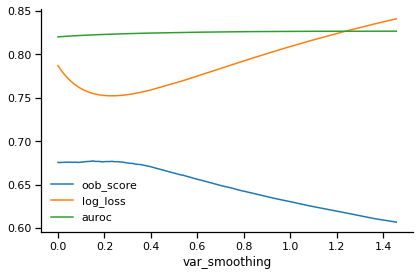

time: 34 s


In [16]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.12, 0.17, size=11), outfile="var_smoothing9"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.12, 0.17, size=11), outfile="var_smoothing10"
)

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
103       0.148414   0.677105  0.754962  0.822253
220       0.148896   0.677105  0.754925  0.822259
226       0.146812   0.677094  0.755086  0.822235
348       0.147016   0.677094  0.755070  0.822237
113       0.147066   0.677094  0.755067  0.822238
44        0.147077   0.677094  0.755066  0.822238
1         0.149717   0.677094  0.754863  0.822268
211       0.149748   0.677094  0.754861  0.822268
15        0.148451   0.677082  0.754959  0.822253
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134
190       0.227772   0.676569  0.752098  0.823067


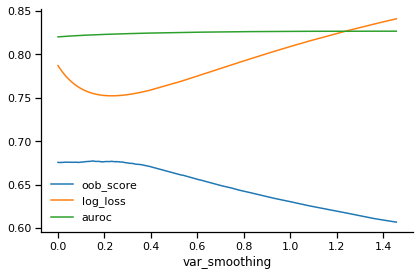

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
44        0.147077   0.677094  0.755066  0.822238
113       0.147066   0.677094  0.755067  0.822238
348       0.147016   0.677094  0.755070  0.822237
226       0.146812   0.677094  0.755086  0.822235
1         0.149717   0.677094  0.754863  0.822268
211       0.149748   0.677094  0.754861  0.822268
15        0.148451   0.677082  0.754959  0.822253
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
366       0.229395   0.676650  0.752095  0.823082
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134


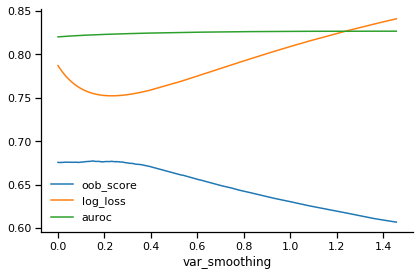

time: 33.6 s


In [17]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.21, 0.25, size=11), outfile="var_smoothing11"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.21, 0.25, size=11), outfile="var_smoothing12"
)

  0%|          | 0/17 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
44        0.147077   0.677094  0.755066  0.822238
1         0.149717   0.677094  0.754863  0.822268
113       0.147066   0.677094  0.755067  0.822238
348       0.147016   0.677094  0.755070  0.822237
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
15        0.148451   0.677082  0.754959  0.822253
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
366       0.229395   0.676650  0.752095  0.823082
179       0.234877   0.676499  0.752098  0.823132
155       0.235058   0.676475  0.752098  0.823134


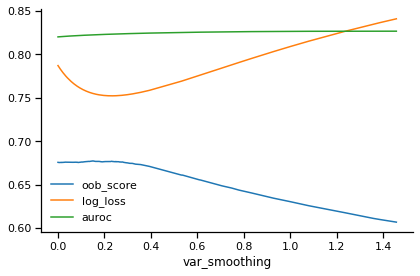

  0%|          | 0/17 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
332       0.151110   0.677129  0.754760  0.822284
402       0.151255   0.677117  0.754749  0.822285
220       0.148896   0.677105  0.754925  0.822259
103       0.148414   0.677105  0.754962  0.822253
226       0.146812   0.677094  0.755086  0.822235
211       0.149748   0.677094  0.754861  0.822268
1         0.149717   0.677094  0.754863  0.822268
44        0.147077   0.677094  0.755066  0.822238
348       0.147016   0.677094  0.755070  0.822237
113       0.147066   0.677094  0.755067  0.822238
     var_smoothing  oob_score  log_loss     auroc
157       0.230755   0.676709  0.752094  0.823095
406       0.230234   0.676709  0.752094  0.823090
170       0.230089   0.676720  0.752094  0.823089
198       0.229902   0.676709  0.752095  0.823087
132       0.229770   0.676674  0.752095  0.823086
189       0.233271   0.676639  0.752095  0.823118
366       0.229395   0.676650  0.752095  0.823082
179       0.234877   0.676499  0.752098  0.823132


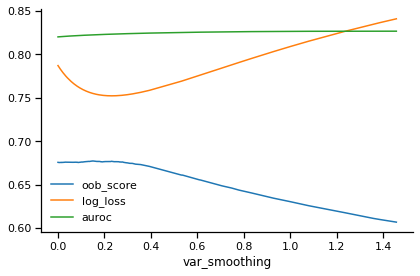

time: 52.6 s


In [18]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.145, 0.235, size=17), outfile="var_smoothing11"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.145, 0.235, size=17), outfile="var_smoothing12"
)

In [19]:
files = [
    "var_smoothing1.feather",
    "var_smoothing2.feather",
    "var_smoothing3.feather",
    "var_smoothing4.feather",
    "var_smoothing5.feather",
    "var_smoothing6.feather",
    "var_smoothing7.feather",
    "var_smoothing8.feather",
    "var_smoothing9.feather",
    "var_smoothing10.feather",
    "var_smoothing11.feather",
    "var_smoothing12.feather",
]
df = pd.concat(
    [pd.read_feather(f"{DATA_OUT_FOLDER}/{file}") for file in files],
    axis="rows",
)

time: 145 ms


<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

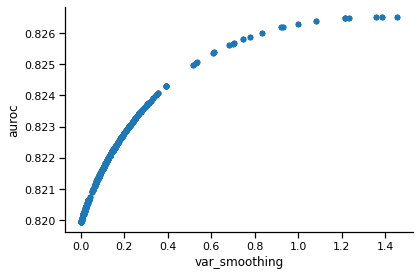

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

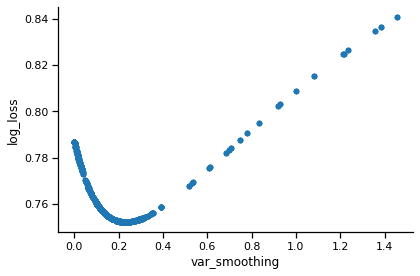

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

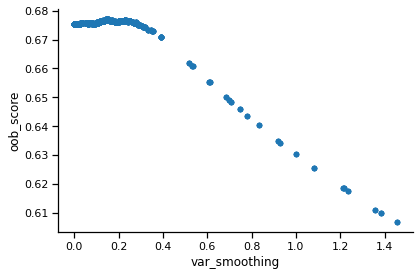

time: 656 ms


In [20]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.sort_values(by="var_smoothing").plot(x="var_smoothing", y=metric, kind="scatter")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [21]:
# best
df = df.drop_duplicates()
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.oob_score == df.oob_score.max()].sort_values(by="log_loss", ascending=True)
df.loc[df.auroc == df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc
158,0.230755,0.676709,0.752094,0.823095


,var_smoothing,oob_score,log_loss,auroc
221,0.15111,0.677129,0.75476,0.822284


,var_smoothing,oob_score,log_loss,auroc
329,1.456516,0.606695,0.840756,0.826516


time: 32 ms


In [22]:
# next best
df.sort_values(by="log_loss", ascending=True).head(11).tail(10)
df.sort_values(by="oob_score", ascending=False).head(11).tail(10)
df.sort_values(by="auroc", ascending=False).head(11).tail(10)

,var_smoothing,oob_score,log_loss,auroc
339,0.230234,0.676709,0.752094,0.823090
157,0.230089,0.676720,0.752094,0.823089
156,0.229902,0.676709,0.752095,0.823087
115,0.229770,0.676674,0.752095,0.823086
159,0.233271,0.676639,0.752095,0.823118
319,0.229395,0.676650,0.752095,0.823082
160,0.234877,0.676499,0.752098,0.823132
161,0.235058,0.676475,0.752098,0.823134
154,0.227772,0.676569,0.752098,0.823067
153,0.226914,0.676464,0.752101,0.823059


,var_smoothing,oob_score,log_loss,auroc
229,0.151255,0.677117,0.754749,0.822285
162,0.148896,0.677105,0.754925,0.822259
88,0.148414,0.677105,0.754962,0.822253
24,0.149717,0.677094,0.754863,0.822268
22,0.147077,0.677094,0.755066,0.822238
157,0.146812,0.677094,0.755086,0.822235
86,0.147066,0.677094,0.755067,0.822238
165,0.149748,0.677094,0.754861,0.822268
216,0.147016,0.677094,0.755070,0.822237
23,0.148451,0.677082,0.754959,0.822253


,var_smoothing,oob_score,log_loss,auroc
314,1.385209,0.609727,0.836316,0.826513
327,1.358264,0.610952,0.834588,0.826510
326,1.234169,0.617576,0.826264,0.826477
313,1.214905,0.618603,0.824916,0.826469
324,1.214303,0.618638,0.824874,0.826469
312,1.079859,0.625566,0.815041,0.826380
322,0.999825,0.630254,0.808835,0.826296
321,0.928095,0.634255,0.803058,0.826195
320,0.919001,0.634721,0.802311,0.826181
319,0.832761,0.640308,0.795093,0.826016


time: 27 ms


In [23]:
df["diff"] = df.log_loss - df.oob_score
df.sort_values(by="diff", ascending=True).head(10)

,var_smoothing,oob_score,log_loss,auroc,diff
157,0.230089,0.676720,0.752094,0.823089,0.075374
158,0.230755,0.676709,0.752094,0.823095,0.075385
339,0.230234,0.676709,0.752094,0.823090,0.075386
156,0.229902,0.676709,0.752095,0.823087,0.075386
115,0.229770,0.676674,0.752095,0.823086,0.075421
319,0.229395,0.676650,0.752095,0.823082,0.075445
159,0.233271,0.676639,0.752095,0.823118,0.075456
154,0.227772,0.676569,0.752098,0.823067,0.075530
160,0.234877,0.676499,0.752098,0.823132,0.075599
37,0.238281,0.676499,0.752109,0.823163,0.075611


time: 13 ms


<AxesSubplot:xlabel='var_smoothing'>

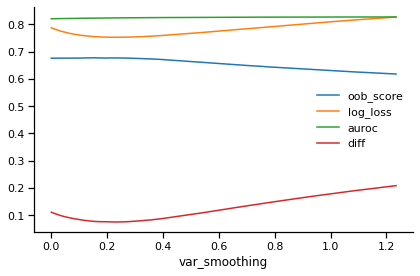

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

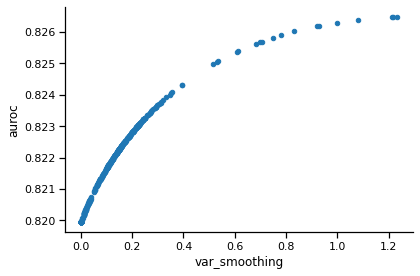

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

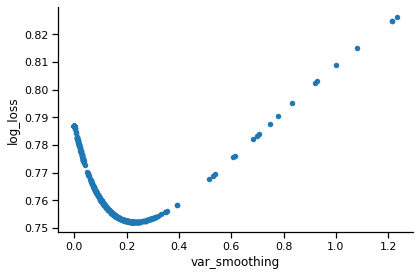

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

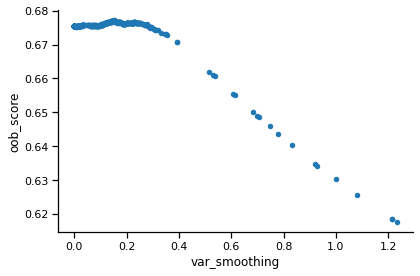

time: 844 ms


In [29]:
good_df = df.loc[df.var_smoothing < 1.25]
good_df = good_df.loc[
    good_df.auroc < 0.826516
]  # the top auroc models are probably overfit
# get the spots between the two observed training optima

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='var_smoothing'>

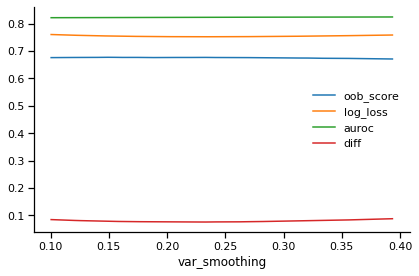

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

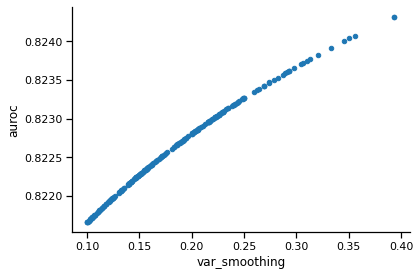

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

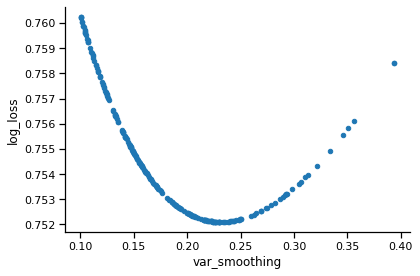

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

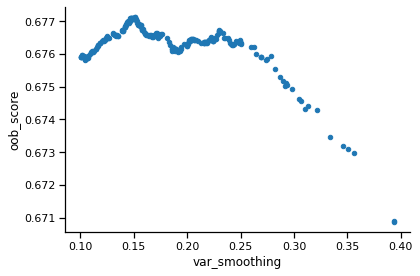

time: 1.04 s


In [31]:
good_df = df.loc[df.var_smoothing < 0.4]
good_df = good_df.loc[good_df.var_smoothing > 0.1]
good_df = good_df.loc[good_df.auroc < 0.826516]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [34]:
# better bests
good_df.loc[good_df.log_loss == good_df.log_loss.min()]
good_df.loc[good_df.oob_score == good_df.oob_score.max()]
good_df.loc[good_df["diff"] == good_df["diff"].min()]

,var_smoothing,oob_score,log_loss,auroc,diff
158,0.230755,0.676709,0.752094,0.823095,0.075385


,var_smoothing,oob_score,log_loss,auroc,diff
221,0.15111,0.677129,0.75476,0.822284,0.077631


,var_smoothing,oob_score,log_loss,auroc,diff
157,0.230089,0.67672,0.752094,0.823089,0.075374


time: 27 ms


In [35]:
final_gnb = BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=0.23),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
_ = gc_collect()

time: 122 ms


In [36]:
final_gnb.fit(data.loc[:, gnb_features], labels.valence)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished


BaggingClassifier(base_estimator=GaussianNB(var_smoothing=0.23),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=2022,
                  verbose=1)

time: 3.69 s


In [37]:
final_gnb.oob_score_
log_loss(y_true, final_gnb.predict_proba(data.loc[:, gnb_features]))
roc_auc_score(
    y_true, final_gnb.predict_proba(data.loc[:, gnb_features]), multi_class="ovo"
)

0.6767086540704456

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


0.7520944551913444

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


0.8230878606283608

time: 1.18 s


# Discussion

There looks to be a sweet spot in training loss. We chose a balance between training log loss and OOB accuracy.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [38]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 2491.867394208908 s
time: 123 ms


[^top](#Contents)